# Сессионое задание по RL

In [1]:
# Установка зависимостей
# Необходимо выполнить, если окружение не нстроено (или в Colab).

!pip -q install -U "torch>=2.0" "matplotlib" "numpy" "pandas"
!pip -q install -U "gymnasium>=0.29" "stable-baselines3[extra]>=2.2" "imageio>=2.31" "imageio-ffmpeg>=0.4.9"

import gymnasium as gym
import stable_baselines3
import torch
print("gymnasium:", gym.__version__)
print("stable-baselines3:", stable_baselines3.__version__)
print("torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


gymnasium: 1.2.3
stable-baselines3: 2.7.1
torch: 2.5.1.post7
CUDA available: False


In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import torch
import random
import gymnasium as gym
import matplotlib.pyplot as plt

from gymnasium import spaces
from dataclasses import dataclass
from typing import Dict, Optional, Any
from stable_baselines3 import PPO, SAC, DQN
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from IPython.display import HTML, display, Image
from matplotlib import animation

In [2]:
# Фиксируем seed для воспроизводимости эксперементов
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_random_seed(SEED)

# Определение устройства
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Задаем путь к папке с видео
ROOT_DIR = "rl_runs"
os.makedirs(ROOT_DIR, exist_ok=True)

Using device: cuda


## Трек 1. Обучение агента в классической среде

Для быстроты вычислений возьмем срезу Pendulum-v1

In [3]:
def make_env(env_id: str, seed: int, render_mode: Optional[str] = None):
    # Создаёт среду Gymnasium + Monitor (для корректных эпизодных метрик).
    # render_mode нужен только для видео (rgb_array).
    env = gym.make(env_id, render_mode=render_mode)
    env = Monitor(env)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def make_vec_env(env_id: str, seed: int):
    # SB3 ожидает VecEnv. Для простоты используем DummyVecEnv (1 среда) + VecMonitor.
    def _thunk():
        return make_env(env_id, seed=seed, render_mode=None)
    vec = DummyVecEnv([_thunk])
    vec = VecMonitor(vec)  # собирает episode returns/lengths
    return vec


def make_eval_env(env_id: str, seed: int):
    # Отдельная среда для оценки (evaluation), чтобы не мешать обучению.
    return make_vec_env(env_id, seed=seed)


def load_evaluations_npz(eval_npz_path: str):
    # Загружает файл evaluations.npz, который создаёт EvalCallback.
    data = np.load(eval_npz_path)
    timesteps = data["timesteps"]
    results = data["results"]  # shape: (n_evals, n_eval_episodes)
    mean_rewards = results.mean(axis=1)
    std_rewards = results.std(axis=1)
    return timesteps, mean_rewards, std_rewards


In [4]:
@dataclass
class RunConfig:
    run_name: str
    algo: str                 # "PPO" or "SAC"
    total_timesteps: int
    eval_freq: int
    n_eval_episodes: int
    gamma: Optional[float] = None
    policy_kwargs: Optional[Dict[str, Any]] = None
    algo_kwargs: Optional[Dict[str, Any]] = None


def train_one_run(env_id: str, seed: int, cfg: RunConfig):
    # Обучает один запуск и возвращает путь к сохранённой модели и evaluation-логам.
    run_dir = os.path.join(ROOT_DIR, cfg.run_name)
    os.makedirs(run_dir, exist_ok=True)

    train_env = make_vec_env(env_id, seed=seed)
    eval_env = make_eval_env(env_id, seed=seed + 1000)  # другой seed для честной оценки

    best_model_dir = os.path.join(run_dir, "best_model")
    eval_log_dir = os.path.join(run_dir, "eval_logs")
    os.makedirs(best_model_dir, exist_ok=True)
    os.makedirs(eval_log_dir, exist_ok=True)

    eval_cb = EvalCallback(
        eval_env,
        best_model_save_path=best_model_dir,
        log_path=eval_log_dir,
        eval_freq=cfg.eval_freq,
        n_eval_episodes=cfg.n_eval_episodes,
        deterministic=True,
        render=False,
    )

    algo_kwargs = dict(cfg.algo_kwargs or {})
    if cfg.gamma is not None:
        algo_kwargs["gamma"] = cfg.gamma

    if cfg.algo.upper() == "PPO":
        policy_kwargs = cfg.policy_kwargs or dict(net_arch=dict(pi=[256, 256], vf=[256, 256]))
        model = PPO(
            "MlpPolicy",
            train_env,
            seed=seed,
            verbose=0,
            device=DEVICE,
            policy_kwargs=policy_kwargs,
            **algo_kwargs,
        )
    elif cfg.algo.upper() == "SAC":
        policy_kwargs = cfg.policy_kwargs or dict(net_arch=[256, 256])
        model = SAC(
            "MlpPolicy",
            train_env,
            seed=seed,
            verbose=0,
            device=DEVICE,
            policy_kwargs=policy_kwargs,
            **algo_kwargs,
        )
    else:
        raise ValueError(f"Unknown algo: {cfg.algo}")

    model.learn(total_timesteps=cfg.total_timesteps, callback=eval_cb)

    final_model_path = os.path.join(run_dir, f"{cfg.run_name}_final.zip")
    model.save(final_model_path)

    eval_npz_path = os.path.join(eval_log_dir, "evaluations.npz")
    return final_model_path, best_model_dir, eval_npz_path


In [5]:
def plot_runs(title: str, run_to_eval_npz: Dict[str, str]):
    plt.figure(figsize=(10, 5))
    for label, npz_path in run_to_eval_npz.items():
        timesteps, mean_r, std_r = load_evaluations_npz(npz_path)
        plt.plot(timesteps, mean_r, label=label)
        plt.fill_between(timesteps, mean_r - std_r, mean_r + std_r, alpha=0.2)
    plt.xlabel("Timesteps")
    plt.ylabel("Mean reward (eval)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


## Эксперимент 1 — PPO vs SAC (одинаковый budget timesteps)

**Контроль:** одинаковые `total_timesteps`, одинаковая архитектура (2×256), одинаковый seed, одинаковая схема оценки (EvalCallback).

Запускаем 2 обучения и строим график `mean eval reward` vs `timesteps`.


/home/simon/anaconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
/home/simon/anaconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-933.11 +/- 271.78
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=-1147.38 +/- 309.34
Episode length: 200.00 +/- 0.00
Eval num_timesteps=15000, episode_reward=-1256.13 +/- 138.32
Episode length: 200.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=-1161.53 +/- 228.99
Episode length: 200.00 +/- 0.00
Eval num_timesteps=25000, episode_reward=-1144.44 +/- 134.56
Episode length: 200.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=-1093.40 +/- 105.80
Episode length: 200.00 +/- 0.00
Eval num_timesteps=35000, episode_reward=-1245.45 +/- 313.93
Episode length: 200.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-1549.98 +/- 180.53
Episode length: 200.00 +/- 0.00
Eval num_timesteps=45000, episode_reward=-1276.26 +/- 152.68
Episode length: 200.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=-1233.24 +/- 127.46
Episode length: 200.00 +/- 0.00
Eval num_timesteps=55000, episode_reward=-1070.82 

/home/simon/anaconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-82.63 +/- 58.02
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=-166.47 +/- 60.24
Episode length: 200.00 +/- 0.00
Eval num_timesteps=15000, episode_reward=-161.18 +/- 56.47
Episode length: 200.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=-117.25 +/- 93.02
Episode length: 200.00 +/- 0.00
Eval num_timesteps=25000, episode_reward=-121.26 +/- 6.30
Episode length: 200.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=-119.54 +/- 4.97
Episode length: 200.00 +/- 0.00
Eval num_timesteps=35000, episode_reward=-163.62 +/- 56.86
Episode length: 200.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-270.80 +/- 51.55
Episode length: 200.00 +/- 0.00
Eval num_timesteps=45000, episode_reward=-215.46 +/- 66.30
Episode length: 200.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=-163.40 +/- 147.87
Episode length: 200.00 +/- 0.00
Eval num_timesteps=55000, episode_reward=-202.09 +/- 55.39
Episode leng

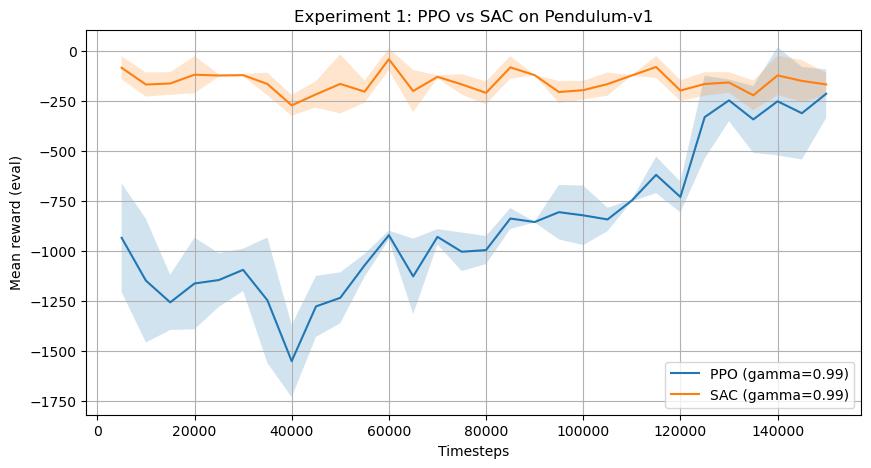

In [6]:
# Гипер параметры для CUDA на CPU может долго считать
TOTAL_TIMESTEPS = 150_000
EVAL_FREQ = 5_000
N_EVAL_EPISODES = 3

exp1_cfgs = [
    RunConfig(
        run_name="exp1_ppo",
        algo="PPO",
        total_timesteps=TOTAL_TIMESTEPS,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        gamma=0.99,
        algo_kwargs=dict(
            n_steps=2048,
            batch_size=64,
            learning_rate=3e-4,
            ent_coef=0.0,
        ),
    ),
    RunConfig(
        run_name="exp1_sac",
        algo="SAC",
        total_timesteps=TOTAL_TIMESTEPS,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        gamma=0.99,
        algo_kwargs=dict(
            learning_rate=3e-4,
            buffer_size=200_000,
            batch_size=256,
            train_freq=1,
            gradient_steps=1,
        ),
    ),
]

exp1_paths = {}
for cfg in exp1_cfgs:
    final_model_path, best_model_dir, eval_npz = train_one_run(env_id="Pendulum-v1", seed=SEED, cfg=cfg)
    exp1_paths[cfg.run_name] = dict(final_model=final_model_path, best_dir=best_model_dir, eval_npz=eval_npz)
    print(cfg.run_name, "->", eval_npz)

plot_runs("Experiment 1: PPO vs SAC on Pendulum-v1", {
    "PPO (gamma=0.99)": exp1_paths["exp1_ppo"]["eval_npz"],
    "SAC (gamma=0.99)": exp1_paths["exp1_sac"]["eval_npz"],
})


## Эксперимент 2 — влияние `gamma` на PPO

**Контроль:** один и тот же алгоритм (PPO), одинаковые `total_timesteps`, те же сетевые архитектуры и прочие гиперпараметры. Меняем только `gamma`.

Сравним:
- PPO `gamma=0.80`
- PPO `gamma=0.99`


Eval num_timesteps=5000, episode_reward=-1110.30 +/- 187.31
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=-1493.86 +/- 203.21
Episode length: 200.00 +/- 0.00
Eval num_timesteps=15000, episode_reward=-1597.12 +/- 92.05
Episode length: 200.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=-1412.55 +/- 218.44
Episode length: 200.00 +/- 0.00
Eval num_timesteps=25000, episode_reward=-1422.23 +/- 77.51
Episode length: 200.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=-1437.83 +/- 33.17
Episode length: 200.00 +/- 0.00
Eval num_timesteps=35000, episode_reward=-1390.64 +/- 74.94
Episode length: 200.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-1487.90 +/- 11.03
Episode length: 200.00 +/- 0.00
Eval num_timesteps=45000, episode_reward=-1417.50 +/- 110.69
Episode length: 200.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=-1254.90 +/- 116.24
Episode length: 200.00 +/- 0.00
Eval num_timesteps=55000, episode_reward=-1291.65 +/- 

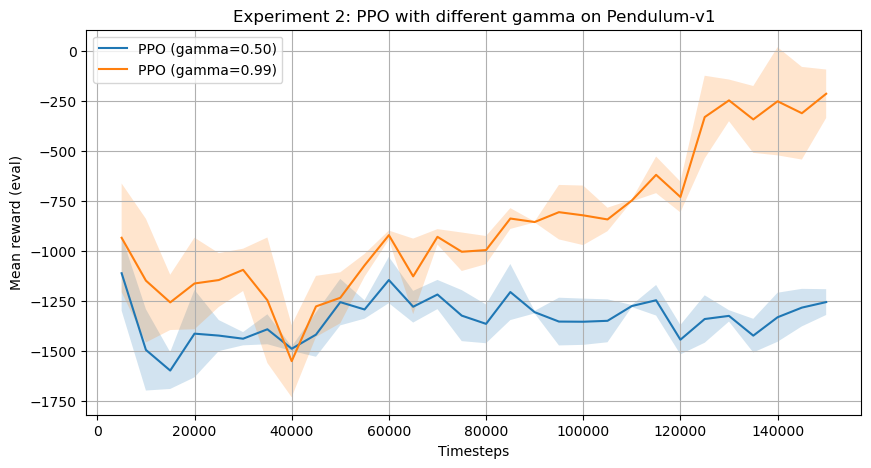

In [7]:
exp2_cfgs = [
    RunConfig(
        run_name="exp2_ppo_gamma_090",
        algo="PPO",
        total_timesteps=TOTAL_TIMESTEPS,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        gamma=0.50,
        algo_kwargs=dict(
            n_steps=2048,
            batch_size=64,
            learning_rate=3e-4,
            ent_coef=0.0,
        ),
    ),
    RunConfig(
        run_name="exp2_ppo_gamma_099",
        algo="PPO",
        total_timesteps=TOTAL_TIMESTEPS,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        gamma=0.99,
        algo_kwargs=dict(
            n_steps=2048,
            batch_size=64,
            learning_rate=3e-4,
            ent_coef=0.0,
        ),
    ),
]

exp2_paths = {}
for cfg in exp2_cfgs:
    final_model_path, best_model_dir, eval_npz = train_one_run(env_id="Pendulum-v1", seed=SEED, cfg=cfg)
    exp2_paths[cfg.run_name] = dict(final_model=final_model_path, best_dir=best_model_dir, eval_npz=eval_npz)
    print(cfg.run_name, "->", eval_npz)

plot_runs("Experiment 2: PPO with different gamma on Pendulum-v1", {
    "PPO (gamma=0.50)": exp2_paths["exp2_ppo_gamma_090"]["eval_npz"],
    "PPO (gamma=0.99)": exp2_paths["exp2_ppo_gamma_099"]["eval_npz"],
})


## Выводы по экспериментам (шаблон)

Заполните этот блок после запуска ячеек обучения и построения графиков.

### Эксперимент 1 (PPO vs SAC)
- Алгоритм SAC почти сразу (уже с первых ~10–20k шагов) выходит на уровень примерно −250…−150 и дальше держится довольно стабильно. Разброс небольшой, а следовательно обучение устойчивое.

- Алгоритм PPO Начинает заметно хуже (примерно −900, −1500) и достаточно долго обучается до приемлемых результатов. До ~100k шагов он остаётся значительно слабее SAC, и только ближе к 130–150k поднимается до ~−300, −200. При этом имеется значительный разброс, что говорит о нестабильности обучения.

- У PPO на большей части обучения разброс больше, особенно в первой половине обучения, а следовательно стабильность ниже, результаты сильнее зависят от конкретных траекторий/обновлений.

__Вывод:__ SAC значительно быстрее выходит на хороший уровень и держится стабильнее, тогда как PPO требует больше шагов, чтобы приблизиться к нему. Но стоит отметить, что SAC требует большего количества вычеслительных ресурсов, так как его обучение запметно долбше по времени в отличии от PPO

### Эксперимент 2 (gamma для PPO)
- PPO (gamma=0.99) постепенно и довольно уверенно улучшает качество политики: примерно с −1200 в начале до уровня около −300, −200 к концу обучения (140–150k timesteps).

- PPO (gamma=0.50) остаётся на низком уровне почти весь запуск: колеблется примерно в районе −1500, −1200, то есть заметного прогресса нет (и к концу он всё ещё существенно хуже).

__Выводы:__

- Слишком маленькое gamma=0.50 сильно ухудшает обучение PPO на Pendulum-v1: агент становится “слишком близоруким”, недооценивает пользу удержания маятника в хорошем состоянии на горизонте будущих шагов, следовательно политика не улучшается.

- gamma=0.99 даёт агенту достаточно длинный горизонт планирования, что критично для Pendulum: награда “за стабилизацию” распределена по времени, и её нужно учитывать не только в ближайшие 1–2 шага.


## Количественная оценка финального агента (20 эпизодов)

Ниже мы:
1) загружаем **best model** из выбранного прогона (можно выбрать вручную),
2) считаем среднюю награду на 20 эпизодах.

**Важно:** В Pendulum-v1 награда обычно отрицательная; чем ближе к 0 — тем лучше.


In [8]:
# Выберите, какой best-model оценивать и визуализировать:
# Например: "exp1_sac", "exp1_ppo", "exp2_ppo_gamma_099"
BEST_RUN_NAME = "exp1_sac"

best_model_path = os.path.join(ROOT_DIR, BEST_RUN_NAME, "best_model", "best_model.zip")
assert os.path.exists(best_model_path), f"Best model not found: {best_model_path}"

if "sac" in BEST_RUN_NAME.lower():
    model = SAC.load(best_model_path, device=DEVICE)
else:
    model = PPO.load(best_model_path, device=DEVICE)

eval_env = make_eval_env("Pendulum-v1", seed=SEED + 2026)

mean_r, std_r = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=20,
    deterministic=True,
    return_episode_rewards=False,
)

print(f"Final agent evaluation over 20 episodes: mean_reward={mean_r:.2f} ± {std_r:.2f}")


Final agent evaluation over 20 episodes: mean_reward=-124.44 ± 85.11


## Видео / анимация финального агента

Сохраняем mp4 (если доступны зависимости). Если mp4 не создаётся из-за ffmpeg, создадим GIF.


In [9]:
import base64
import imageio
from pathlib import Path

def record_episode(model, env_id: str, seed: int = 0, max_steps: int = 200):
    # Прогоняет 1 эпизод и возвращает список кадров (RGB).
    render_env = make_env(env_id, seed=seed, render_mode="rgb_array")
    obs, _ = render_env.reset(seed=seed)

    frames = []
    for _ in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = render_env.step(action)
        frames.append(render_env.render())
        if terminated or truncated:
            break

    render_env.close()
    return frames


def save_mp4(frames, out_path: str, fps: int = 30):
    # Сохраняет mp4 через imageio (нужен imageio-ffmpeg).
    with imageio.get_writer(out_path, fps=fps) as writer:
        for f in frames:
            writer.append_data(f)


def save_gif(frames, out_path: str, fps: int = 30):
    imageio.mimsave(out_path, frames, duration=1/fps)


def show_file_as_html(file_path: str, mime: str, tag: str = "video", width: int = 640, height: int = 480):
    # Встраивает файл (mp4/gif) прямо в вывод ноутбука (base64).
    data = Path(file_path).read_bytes()
    b64 = base64.b64encode(data).decode("ascii")

    if tag == "video":
        html = (
            f'<video width="{width}" height="{height}" controls>'
            f'<source src="data:{mime};base64,{b64}" type="{mime}">'
            f"</video>"
        )
    elif tag == "img":
        html = f'<img src="data:{mime};base64,{b64}" width="{width}">'
    else:
        raise ValueError("tag must be 'video' or 'img'")

    display(HTML(html))


# --- Запись 1 эпизода и визуализация ---
video_dir = os.path.join(ROOT_DIR, BEST_RUN_NAME, "video")
Path(video_dir).mkdir(parents=True, exist_ok=True)
mp4_path = os.path.join(video_dir, "final_agent.mp4")
gif_path = os.path.join(video_dir, "final_agent.gif")

frames = record_episode(model, "Pendulum-v1", seed=SEED + 7, max_steps=200)

try:
    save_mp4(frames, mp4_path, fps=30)
    show_file_as_html(mp4_path, mime="video/mp4", tag="video", width=640, height=480)
    print("Saved mp4:", mp4_path)
except Exception as e:
    print("MP4 failed (likely ffmpeg). Fallback to GIF. Error:", e)
    save_gif(frames, gif_path, fps=30)
    show_file_as_html(gif_path, mime="image/gif", tag="img", width=640, height=480)
    print("Saved gif:", gif_path)


/home/simon/anaconda3/envs/rl/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved mp4: rl_runs/exp1_sac/video/final_agent.mp4


## Таблица итоговых оценок для всех запусков (опционально)

Считаем среднюю награду по 10 эпизодам для каждого `best_model`.


In [10]:
import pandas as pd

def eval_best(run_name: str, n_episodes: int = 10):
    best_model_path = os.path.join(ROOT_DIR, run_name, "best_model", "best_model.zip")
    if not os.path.exists(best_model_path):
        return None

    if "sac" in run_name.lower():
        m = SAC.load(best_model_path, device=DEVICE)
    else:
        m = PPO.load(best_model_path, device=DEVICE)

    env = make_eval_env("Pendulum-v1", seed=SEED + 5000)
    mean_r, std_r = evaluate_policy(m, env, n_eval_episodes=n_episodes, deterministic=True)
    return mean_r, std_r

all_runs = []
for d in sorted(os.listdir(ROOT_DIR)):
    if os.path.isdir(os.path.join(ROOT_DIR, d)):
        res = eval_best(d, n_episodes=10)
        if res is not None:
            all_runs.append({"run": d, "mean_reward_10ep": res[0], "std_reward_10ep": res[1]})

df = pd.DataFrame(all_runs).sort_values("mean_reward_10ep", ascending=False)
df


/home/simon/anaconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/simon/anaconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


,run,mean_reward_10ep,std_reward_10ep
1,exp1_sac,-160.413849,95.508148
0,exp1_ppo,-235.928757,159.826752
3,exp2_ppo_gamma_099,-235.928757,159.826752
2,exp2_ppo_gamma_090,-1323.064331,308.629852


## Трек 2. Исследование применимости RL для своей задачи

Собственная среда: `GridWorldShapingEnv`

Идея:
- 2D-сетка `N x N`
- Старт в левом верхнем углу `(0,0)`
- Цель в правом нижнем `(N-1, N-1)`
- Есть **стены** (непроходимые клетки) и **ямы** (терминальные клетки со штрафом)
- Дискретные действия: `шаг вверх, шаг вправо, шаг вниз, шаг влево, стоять`
- Наблюдение: координаты агента **(x, y)**, нормированные в `[0, 1]`

In [11]:
class GridWorldShapingEnv(gym.Env):
    '''
    Простая 2D GridWorld среда.

    reward_type:
      - "sparse": награда только на терминалах + маленький step penalty
      - "dense": дополнительно награда за приближение к цели (reward shaping)
    '''

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 6}

    def __init__(
        self,
        size: int = 7,
        max_steps: int = 50,
        reward_type: str = "sparse",
        seed: int = 42,
        render_mode: str | None = None,
    ):
        super().__init__()
        assert reward_type in ("sparse", "dense")
        assert render_mode in (None, "human", "rgb_array")

        self.size = size
        self.max_steps = max_steps
        self.reward_type = reward_type
        self.render_mode = render_mode

        # Действия: up, right, down, left, stay
        self.action_space = spaces.Discrete(5)

        # Наблюдение: (x, y) в [0, 1]
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(2,), dtype=np.float32
        )

        # Карта фиксируется seed'ом для воспроизводимости
        self._build_map(seed)

        self.agent_pos = None
        self.steps = 0

    def _build_map(self, seed: int):
        # Создаём фиксированную карту стен и ям (детерминированную, воспроизводимую).
        N = self.size

        # Старт и цель
        self.start = (0, 0)
        self.goal = (N - 1, N - 1)

        # Ручная карта: всегда проходимая (удобно для задания).
        walls = {
            (1, 1), (1, 2), (1, 3),
            (3, 1), (3, 2), (3, 3),
            (5, 3), (5, 4)
        }
        pits = {(2, 5), (4, 4)}  # терминальные "ямы" со штрафом

        # Убедимся, что не конфликтуют со стартом/целью
        walls.discard(self.start); walls.discard(self.goal)
        pits.discard(self.start); pits.discard(self.goal)

        self.walls = walls
        self.pits = pits

    def _get_obs(self):
        x, y = self.agent_pos
        denom = float(self.size - 1) if self.size > 1 else 1.0
        return np.array([x / denom, y / denom], dtype=np.float32)

    def _manhattan(self, a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        self.agent_pos = self.start
        obs = self._get_obs()
        info = {"agent_pos": self.agent_pos}
        if self.render_mode == "human":
            print(self._ascii_render())
        return obs, info

    def step(self, action: int):
        assert self.agent_pos is not None, "Call reset() first"
        self.steps += 1

        x, y = self.agent_pos
        prev_pos = (x, y)

        # Применяем действие
        if action == 0:      # вверх
            new_pos = (x - 1, y)
        elif action == 1:    # вправо
            new_pos = (x, y + 1)
        elif action == 2:    # вниз
            new_pos = (x + 1, y)
        elif action == 3:    # влево
            new_pos = (x, y - 1)
        elif action == 4:    # стоять
            new_pos = (x, y)
        else:
            raise ValueError("Invalid action")

        # Границы
        nx, ny = new_pos
        if nx < 0 or nx >= self.size or ny < 0 or ny >= self.size:
            new_pos = prev_pos

        # Стены непроходимые
        if new_pos in self.walls:
            new_pos = prev_pos

        self.agent_pos = new_pos

        terminated = False
        truncated = False

        step_penalty = -0.01
        reward = step_penalty

        # Проверка терминалов
        if self.agent_pos in self.pits:
            terminated = True
            reward = -1.0
        elif self.agent_pos == self.goal:
            terminated = True
            reward = 1.0
        else:
            if self.reward_type == "dense":
                # Reward shaping: поощряем приближение к цели
                prev_d = self._manhattan(prev_pos, self.goal)
                new_d = self._manhattan(self.agent_pos, self.goal)
                progress = prev_d - new_d  # +1 если приблизились на 1
                reward = step_penalty + 0.1 * float(progress)

        # Ограничение по шагам
        if self.steps >= self.max_steps and not terminated:
            truncated = True

        obs = self._get_obs()
        info = {"agent_pos": self.agent_pos}

        if self.render_mode == "human":
            print(self._ascii_render())

        return obs, reward, terminated, truncated, info

    def _ascii_render(self) -> str:
        N = self.size
        grid = [[" . " for _ in range(N)] for _ in range(N)]
        for (i, j) in self.walls:
            grid[i][j] = "###"
        for (i, j) in self.pits:
            grid[i][j] = " P "
        gx, gy = self.goal
        grid[gx][gy] = " G "
        ax, ay = self.agent_pos
        grid[ax][ay] = " A "
        return "\n".join("".join(row) for row in grid)

    def render(self):
        if self.render_mode is None:
            return None

        if self.render_mode == "human":
            # human-рендер уже печатается в step/reset
            return None

        # rgb_array рендер: вернём картинку (H, W, 3)
        N = self.size
        cell = 24  # размер клетки в пикселях
        img = np.ones((N * cell, N * cell, 3), dtype=np.uint8) * 255

        def fill_cell(pos, color):
            x, y = pos
            x0, x1 = x * cell, (x + 1) * cell
            y0, y1 = y * cell, (y + 1) * cell
            img[x0:x1, y0:y1, :] = np.array(color, dtype=np.uint8)

        # стены/ямы/цель/агент
        for w in self.walls:
            fill_cell(w, (160, 160, 160))
        for p in self.pits:
            fill_cell(p, (220, 80, 80))
        fill_cell(self.goal, (80, 200, 120))
        fill_cell(self.agent_pos, (80, 120, 220))

        # сетка
        for i in range(0, N * cell, cell):
            img[i:i+1, :, :] = 0
            img[:, i:i+1, :] = 0

        return img

    def close(self):
        pass

In [12]:
# Проверим работоспособность среды
# выполним один эпизод со случайными действиями
env = GridWorldShapingEnv(size=7, reward_type="sparse", render_mode="human")
obs, info = env.reset(seed=0)
done = False
total_reward = 0.0

while not done:
    a = env.action_space.sample()
    obs, r, terminated, truncated, info = env.step(a)
    total_reward += r
    done = terminated or truncated

print("episode reward:", total_reward)
env.close()

 A  .  .  .  .  .  . 
 . ######### .  .  . 
 .  .  .  .  .  P  . 
 . ######### .  .  . 
 .  .  .  .  P  .  . 
 .  .  . ###### .  . 
 .  .  .  .  .  .  G 
 A  .  .  .  .  .  . 
 . ######### .  .  . 
 .  .  .  .  .  P  . 
 . ######### .  .  . 
 .  .  .  .  P  .  . 
 .  .  . ###### .  . 
 .  .  .  .  .  .  G 
 A  .  .  .  .  .  . 
 . ######### .  .  . 
 .  .  .  .  .  P  . 
 . ######### .  .  . 
 .  .  .  .  P  .  . 
 .  .  . ###### .  . 
 .  .  .  .  .  .  G 
 .  .  .  .  .  .  . 
 A ######### .  .  . 
 .  .  .  .  .  P  . 
 . ######### .  .  . 
 .  .  .  .  P  .  . 
 .  .  . ###### .  . 
 .  .  .  .  .  .  G 
 .  .  .  .  .  .  . 
 A ######### .  .  . 
 .  .  .  .  .  P  . 
 . ######### .  .  . 
 .  .  .  .  P  .  . 
 .  .  . ###### .  . 
 .  .  .  .  .  .  G 
 .  .  .  .  .  .  . 
 . ######### .  .  . 
 A  .  .  .  .  P  . 
 . ######### .  .  . 
 .  .  .  .  P  .  . 
 .  .  . ###### .  . 
 .  .  .  .  .  .  G 
 .  .  .  .  .  .  . 
 . ######### .  .  . 
 A  .  .  .  .  P  . 
 . #######

## Гипотеза

_Если в простом GridWorld заменить **sparse reward** (награда только в конце) на **dense reward** (награда за приближение к цели), то DQN будет обучаться **быстрее** и достигнет **большей доли успешных эпизодов** при одинаковом бюджете шагов обучения._

- **Вариант A (Sparse):** награда +1 только при достижении цели, штраф -1 за попадание в яму, небольшой штраф за шаг.
- **Вариант B (Dense):** всё как в sparse, но дополнительно даём небольшую награду за уменьшение манхэттенского расстояния до цели (reward shaping).


### Обучение двух агентов (DQN) и оценка

In [13]:
class EpisodeLoggerCallback(BaseCallback):
    '''
    Колбэк, который собирает episode rewards и lengths из Monitor.
    '''
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                self.episode_rewards.append(info["episode"]["r"])
                self.episode_lengths.append(info["episode"]["l"])
        return True

In [14]:
def make_env(reward_type: str, seed: int):
    def _init():
        env = GridWorldShapingEnv(
            size=7,
            max_steps=50,
            reward_type=reward_type,
            seed=seed,
            render_mode=None,
        )
        return Monitor(env)  # добавляет info["episode"]
    return _init


def train_dqn(reward_type: str, total_timesteps: int = 50_000, seed: int = 0):
    vec_env = DummyVecEnv([make_env(reward_type, seed=seed)])

    model = DQN(
        policy="MlpPolicy",
        env=vec_env,
        learning_rate=1e-3,
        buffer_size=20_000,
        learning_starts=1_000,
        batch_size=64,
        gamma=0.99,
        train_freq=4,
        target_update_interval=500,
        exploration_fraction=0.2,
        exploration_final_eps=0.05,
        verbose=0,
        device=DEVICE,
        seed=seed,
    )

    cb = EpisodeLoggerCallback()
    model.learn(total_timesteps=total_timesteps, callback=cb, progress_bar=True)
    return model, cb


TOTAL_STEPS = 50_000
SEED = 0

In [15]:
# Обучаем двух агентов: sparse vs dense

model_sparse, log_sparse = train_dqn("sparse", total_timesteps=TOTAL_STEPS, seed=SEED)
model_dense,  log_dense  = train_dqn("dense",  total_timesteps=TOTAL_STEPS, seed=SEED)

print("episodes collected (sparse):", len(log_sparse.episode_rewards))
print("episodes collected (dense):", len(log_dense.episode_rewards))

Output()

Output()

episodes collected (sparse): 1089
episodes collected (dense): 1067


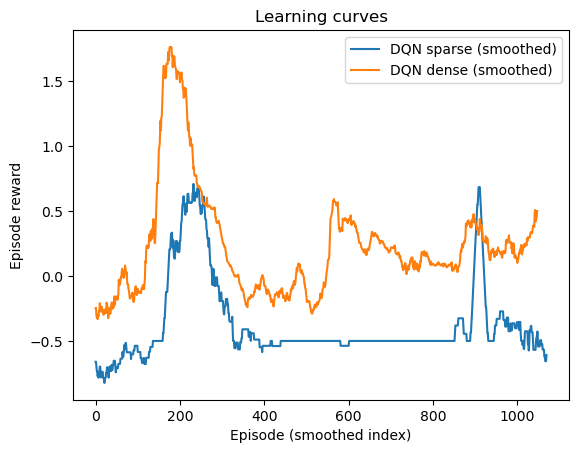

In [16]:
def smooth(y, window=20):
    if len(y) < window:
        return np.array(y, dtype=float)
    y = np.array(y, dtype=float)
    kernel = np.ones(window) / window
    return np.convolve(y, kernel, mode="valid")

plt.figure()
plt.plot(smooth(log_sparse.episode_rewards, 20), label="DQN sparse (smoothed)")
plt.plot(smooth(log_dense.episode_rewards, 20), label="DQN dense (smoothed)")
plt.xlabel("Episode (smoothed index)")
plt.ylabel("Episode reward")
plt.title("Learning curves")
plt.legend()
plt.show()

In [17]:
def evaluate_success(model, reward_type: str, n_episodes: int = 200, seed: int = 123):
    env = GridWorldShapingEnv(size=7, max_steps=50, reward_type=reward_type, seed=seed)
    successes = 0
    rewards = []
    lengths = []

    for ep in range(n_episodes):
        obs, info = env.reset(seed=seed + ep)
        done = False
        total_r = 0.0
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, terminated, truncated, info = env.step(int(action))
            total_r += float(r)
            steps += 1
            done = terminated or truncated

        rewards.append(total_r)
        lengths.append(steps)
        if info["agent_pos"] == env.goal:
            successes += 1

    env.close()
    return {
        "success_rate": successes / n_episodes,
        "mean_reward": float(np.mean(rewards)),
        "std_reward": float(np.std(rewards)),
        "mean_len": float(np.mean(lengths)),
    }

metrics_sparse = evaluate_success(model_sparse, "sparse")
metrics_dense  = evaluate_success(model_dense,  "dense")

pd.DataFrame([metrics_sparse, metrics_dense], index=["sparse", "dense"])

,success_rate,mean_reward,std_reward,mean_len
sparse,0.0,-0.50,1.110223e-16,50.0
dense,1.0,1.99,4.440892e-16,12.0


## Визуализация результатов

In [18]:
def run_episode_collect_frames(model, reward_type: str, seed: int = 0, max_steps: int = 50):
    env = GridWorldShapingEnv(
        size=7,
        max_steps=max_steps,
        reward_type=reward_type,
        seed=seed,
        render_mode="rgb_array",
    )
    obs, info = env.reset(seed=seed)
    frames = [env.render()]
    traj = [env.agent_pos]
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, r, terminated, truncated, info = env.step(int(action))
        frames.append(env.render())
        traj.append(env.agent_pos)
        done = terminated or truncated

    env.close()
    return frames, traj, info

def plot_trajectory(traj, env_size=7, walls=None, pits=None, goal=(6,6), title="Trajectory"):
    walls = walls or set()
    pits = pits or set()

    xs = [p[1] for p in traj]  # по оси X — столбцы
    ys = [p[0] for p in traj]  # по оси Y — строки

    plt.figure()
    plt.xlim(-0.5, env_size-0.5)
    plt.ylim(env_size-0.5, -0.5)
    plt.xticks(range(env_size))
    plt.yticks(range(env_size))
    plt.grid(True)

    for (i, j) in walls:
        plt.scatter(j, i, marker="s", s=400)
    for (i, j) in pits:
        plt.scatter(j, i, marker="s", s=400)

    plt.scatter(goal[1], goal[0], marker="s", s=400, label="goal")
    plt.plot(xs, ys, marker="o")
    plt.scatter(xs[0], ys[0], s=200, label="start")
    plt.scatter(xs[-1], ys[-1], s=200, label="end")

    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()

def save_gif(frames, path, fps=6):
    fig = plt.figure()
    plt.axis("off")
    im = plt.imshow(frames[0])

    def update(i):
        im.set_data(frames[i])
        return (im,)

    anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000/fps, blit=True)
    anim.save(path, writer=animation.PillowWriter(fps=fps))
    plt.close(fig)

### Алгоритм DQN sparse

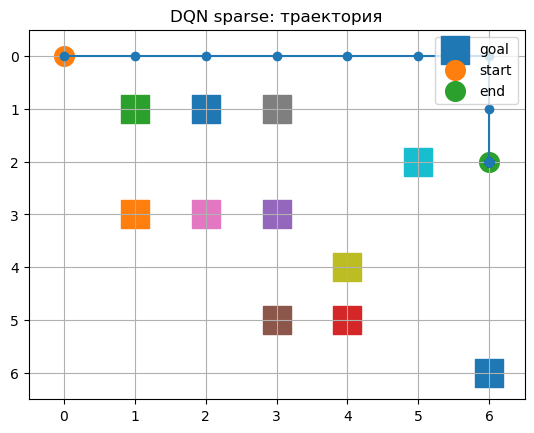

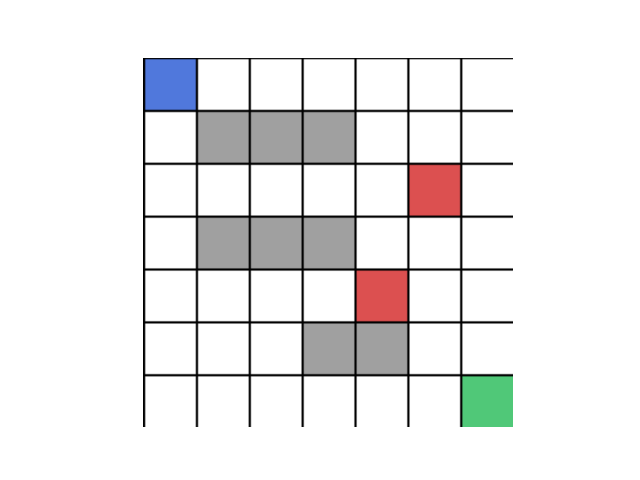

Sparse ended at: (2, 6) goal: (6, 6)


In [19]:
tmp_env = GridWorldShapingEnv(size=7, reward_type="sparse", seed=0)
walls, pits, goal = tmp_env.walls, tmp_env.pits, tmp_env.goal
tmp_env.close()

frames_s, traj_s, info_s = run_episode_collect_frames(model_sparse, "sparse", seed=0)

plot_trajectory(traj_s, env_size=7, walls=walls, pits=pits, goal=goal, title="DQN sparse: траектория")

os.makedirs("artifacts", exist_ok=True)
gif_sparse_path = "artifacts/episode_sparse.gif"
save_gif(frames_s, gif_sparse_path, fps=6)
display(Image(filename=gif_sparse_path))

print("Sparse ended at:", info_s["agent_pos"], "goal:", goal)

### Алгоритм DQN dense

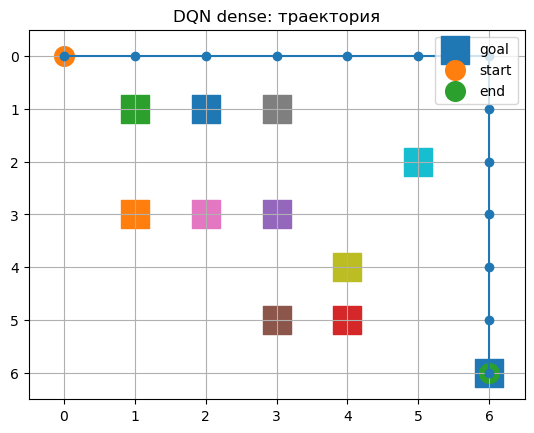

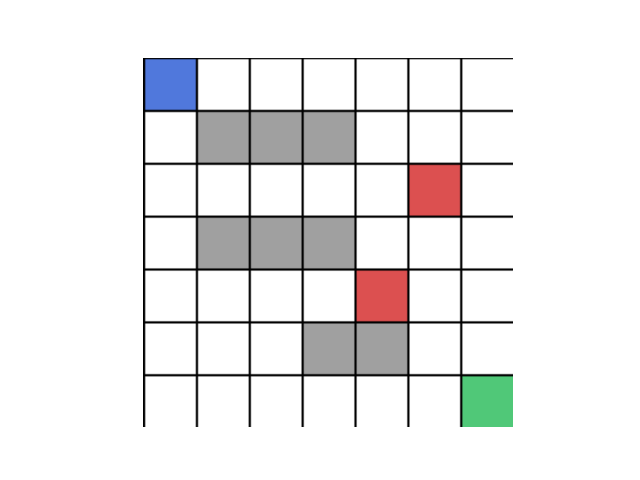

Dense ended at: (6, 6) goal: (6, 6)


In [20]:
tmp_env = GridWorldShapingEnv(size=7, reward_type="sparse", seed=0)
walls, pits, goal = tmp_env.walls, tmp_env.pits, tmp_env.goal
tmp_env.close()

frames_d, traj_d, info_d = run_episode_collect_frames(model_dense,  "dense",  seed=0)
plot_trajectory(traj_d, env_size=7, walls=walls, pits=pits, goal=goal, title="DQN dense: траектория")

os.makedirs("artifacts", exist_ok=True)
gif_dense_path  = "artifacts/episode_dense.gif"
save_gif(frames_d, gif_dense_path, fps=6)
display(Image(filename=gif_dense_path))
print("Dense ended at:",  info_d["agent_pos"], "goal:", goal)

## Анализ результатов

- Алгоритм DQN-dense обучается быстрее и в среднем получает более высокую награду. Так же на визуализации видим, что агент достигает цели;
- Алгоритм DQN-sparse большую часть времени получает отрицательную награду и на визуализации видим, что агент не достигает цели.

__Объяснение результата:__

Dense reward даёт “градиент” почти на каждом шаге (например, за приближение к цели), поэтому агент быстрее понимает, куда двигаться, и чаще получает полезные обновления Q-функции.

Sparse reward даёт сигнал редко (например, только при достижении цели). Из-за этого:
- агент может долго не находить успешные траектории;
- легко “прилипает” к безопасной, но неуспешной стратегии (например, избегает ям/штрафов, но до цели не доходит);
- улучшения могут быть случайными и нестабильными.

## Воспроизводимость: pip freeze

Сохраните вывод как часть отчёта/приложения.


In [22]:
!pip freeze | sed -n '1,200p'

absl-py==2.2.2
aiobotocore @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_aiobotocore_1762893423/work
aiodns @ file:///home/task_176218489250449/conda-bld/aiodns_1762184935305/work
aiohappyeyeballs @ file:///croot/aiohappyeyeballs_1755769838153/work
aiohttp @ file:///home/task_176251938157474/conda-bld/aiohttp_1762519754969/work
aioitertools @ file:///croot/aioitertools_1754313755021/work
aiosignal @ file:///croot/aiosignal_1755870803324/work
alabaster @ file:///home/task_176470914979328/conda-bld/alabaster_1764709164944/work
ale-py==0.11.2
altair @ file:///home/task_176552758748712/conda-bld/altair_1765528007727/work
anaconda-anon-usage @ file:///opt/miniconda3/conda-bld/anaconda-anon-usage_1764636648062/work
anaconda-auth @ file:///home/task_176583888274028/conda-bld/anaconda-cloud-auth-split_1765839823117/work
anaconda-catalogs @ file:///home/task_176485835052758/conda-bld/anaconda-catalogs_1764858972682/work
anaconda-cli-base @ file:///home/task_1764888690544